# 時空間krigingを実装する
- kalman filterによる実装

## Model
$
x_t = x_{t-1} + w_t \\
y_t = F x_t + v_t \\
w_t\sim N(0, \Sigma_x),v_t\sim N(0, \Sigma_y) \\
$

In [1]:
import numpy as np

In [6]:
a = np.identity(3)

In [8]:
np.log(np.linalg.det(a))

0.0

In [39]:
def kalman(y, x, SigP, SigX, SigY, F):
    '''
    カルマンフィルタ
    input:時点tの観測データ, 時点t-1の状態変数,
        分散共分散行列(状態変数, 観測・状態モデル), 状態変数と観測値の関係を表す行列
    output:
    '''
    
    # variance of state variable at t
    SigP0 = SigP + SigX
    
    # mean and variance of predicted likelihood of obs
    # y0_til = np.dot(F, x)
    SX_til = np.dot(np.dot(F, SigP0), F.T) + SigY
    SX_til_inv = np.linalg.inv(SX_til)
    
    # kalman gain
    K = np.dot(np.dot(SigP0, F.T), SX_til_inv)
    
    # update state
    # calculate mean
    y1_til = y - np.dot(F, x)
    x1 = x + np.dot(K, y1_til)
    # calculate variance
    dim = F.shape
    if F == 1:
        dim = [1]
    I = np.identity(dim[0])
    Sig = I - np.dot(K, F)
    SigP1 = np.dot(Sig, SigP0)
    
    # calculate predicted val
    pred = np.dot(F, x1)
    
    # calculate model marginal likelihood at t
    det = np.linalg.det(SX_til)
    var = np.dot(np.dot(y1_til.T, SX_til_inv), y1_til)
    logz = 0.5*(np.log(det) - var)
    
    # pred_val, pred_state, cov-mat of state, log-likeli, 
    return pred, x1, SigP1, logz, SX_til

## 簡単なデータでテストしてみる

In [32]:
nt = 50		#number of time points
n = 1		#number of sample locations
nb = 1		#number of basis functions	
B = 1		#シミュレーションデータ生成用の行列（無視でok）
sigY = np.array(1)		#観測モデルの誤差分散
sigX = np.array(1)		#状態モデルの誤差分散
F = np.array(1)

In [14]:
def norm(sig):
    return np.random.normal(0, sig, 1)

In [15]:
x_list = []
y_list = []
for t in range(1, nt+1):
    if t == 1:
        e1 = norm(sigX)
    else:
        e1 = B*e0 + norm(sigX)
    x = B * e1 + norm(sigX)
    y = x + norm(sigY)
    
    x_list.append(x)
    y_list.append(y)
    e0 = e1

In [18]:
import matplotlib.pyplot as plt

In [19]:
index = [i for i in range(1, len(x_list) + 1)]

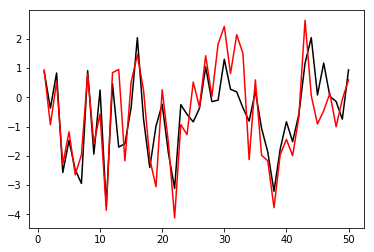

In [23]:
plt.plot(index, x_list, color='black')
plt.plot(index, y_list, color='red')

In [26]:
I = np.identity(n)
SigY = np.dot(sigY, I)
SigX = np.dot(sigX, I)
y_pred_list = []

In [41]:
for t in range(2, nt+1):
    if t == 2:
        x = y_list[0]
        SigP = I
    else:
        x = x1
        SigP = SigP1
    pred, x1, SigP1, logz, a \
    = kalman(y_list[t-1], x, SigP, SigX, SigY, F)
    y_pred_list.append(pred)

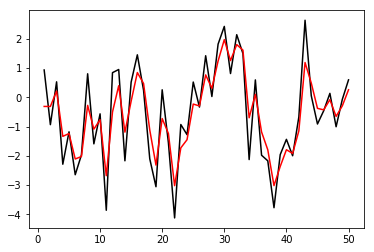

In [42]:
plt.plot(index, y_list, color='black')
plt.plot(index, y_pred_list, color='red')